# Прогнозирование временного ряда выработки электроэнергии

Имеются два временных ряда: первый — это среднесуточная выработка электроэнергии ветряной установкой. 
Другой — среднесуточная выработка электроэнергии при помощи дизельного генератора. Оба показателя измеряются в кВт⋅ч.

Помимо данных двух временных рядов имеются временные ряды дополнительных параметров, таких как скорость ветра, температура воздуха и т.д.

Расшифровка представлена ниже (целевая переменная выделена жирным начертанием):

* datetime - День

* **diesel_fuel_kWh - Выработка эл.энергии ДЭС,  кВтч** 

* wind_power_kWh - Выработка эл.энергии ВЭУ,  кВтч

* diesel_time_h - Время работы дизельной электростанции (ДЭС),  ч

* wind_time_h - Время работы ветряной электроустановки (ВЭУ),  ч 

* velocity_max_msec - Скорость ветра (мах), м/с
 
* velocity_mean_msec - Скорость ветра (ср), м/с

* tmp_grad - Температура окр. среды (ср), град


Задача: построить модель, которая позволяет предсказывать значения временного ряда diesel_fuel_kWh на заданное количество суток вперёд. Таким образом, решается задача предсказания временного ряда.

Для решения задачи используется AutoML фреймворк FEDOT.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Additional custom functions
from processing import prepare_multimodal_data, plot_results, multi_automl_fit_forecast

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

Ниже представлен пример прогнозирования временного ряда на основе использования многомерных временных рядов
## Горизонт прогнозирования 20 элементов
Определим длину прогноза и прочитаем исходный файл

In [2]:
forecast_length = 20
df = pd.read_csv('pw_dataset.csv', parse_dates=['datetime'])

In [4]:
# Wrap time series data into InputData class
features_to_use = ['wind_power_kWh', 'diesel_time_h', 'wind_time_h',
                   'velocity_max_msec', 'velocity_mean_msec', 'tmp_grad',
                   'diesel_fuel_kWh']
ts = np.array(df['diesel_fuel_kWh'])
mm_train, mm_test, = prepare_multimodal_data(dataframe=df,
                                             features=features_to_use,
                                             forecast_length=forecast_length)

In [ ]:
# Prepare parameters for algorithm launch
# timeout 2 - means that AutoML algorithm will work for 2 minutes
composer_params = {'max_depth': 6,
                   'max_arity': 3,
                   'pop_size': 20,
                   'num_of_generations': 100,
                   'timeout': 2,
                   'preset': 'ultra_light',
                   'metric': 'rmse',
                   'cv_folds': None,
                   'validation_blocks': None}
# Посмотрим на получившийся пайплайн при помощи параметра vis=True
forecast, obtained_pipeline = multi_automl_fit_forecast(mm_train, mm_test,
                                                        composer_params,
                                                        ts, forecast_length,
                                                        vis=True)

In [7]:
mse_metric = mean_squared_error(ts[-forecast_length:], forecast, squared=False)
mae_metric = mean_absolute_error(ts[-forecast_length:], forecast)
print(f'MAE - {mae_metric:.2f}')
print(f'RMSE - {mse_metric:.2f}')

MAE - 187.33
RMSE - 223.55


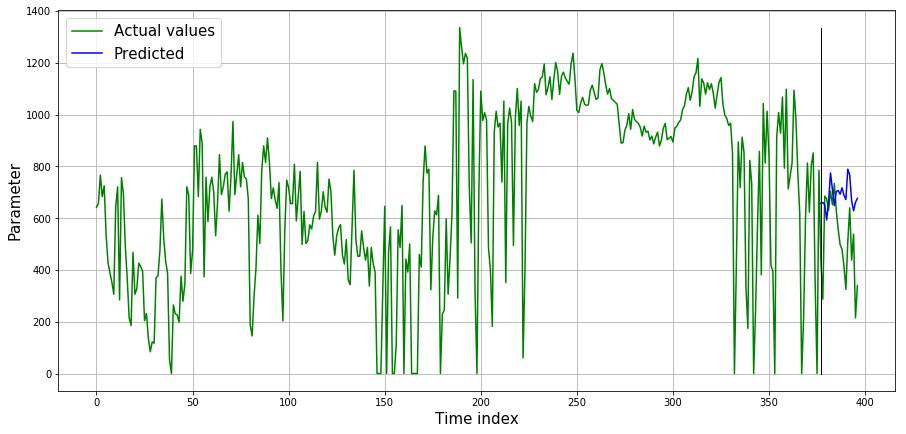

In [8]:
# Visualise predictions
plot_results(actual_time_series=ts,
             predicted_values=forecast,
             len_train_data=len(ts) - forecast_length)

Сохранить пайплайн можно при помощи следующей команды

In [ ]:
# Save obtained pipeline
obtained_pipeline.save('')

В данном случае пайплайн был сохранён в файл "September-15-2021,13-42-06,PM"

Загрузить пайплайн можно при помощи следующих строк кода:

In [10]:
from fedot.core.pipelines.pipeline import Pipeline

load_pipeline = Pipeline()
load_pipeline.load('September-15-2021,13-42-06,PM\.json')

The pipeline was imported from the path: September-15-2021,13-42-06,PM\.json.


## Горизонт прогнозирования 60 элементов

Обёрнем некоторые из вышеперечисленных функций в обвязку, чтобы было удобнее проводить эксперименты

In [18]:
def perform_experiment(forecast_length, timeout=2):
    
    df = pd.read_csv('pw_dataset.csv', parse_dates=['datetime'])
    # Wrap time series data into InputData class
    features_to_use = ['wind_power_kWh', 'diesel_time_h', 'wind_time_h',
                       'velocity_max_msec', 'velocity_mean_msec', 'tmp_grad',
                       'diesel_fuel_kWh']
    ts = np.array(df['diesel_fuel_kWh'])
    mm_train, mm_test, = prepare_multimodal_data(dataframe=df,
                                                 features=features_to_use,
                                                 forecast_length=forecast_length)
    
    # Prepare parameters for algorithm launch
    # timeout 2 - means that AutoML algorithm will work for 2 minutes
    composer_params = {'max_depth': 6,
                       'max_arity': 3,
                       'pop_size': 20,
                       'num_of_generations': 100,
                       'timeout': timeout,
                       'preset': 'ultra_light',
                       'metric': 'rmse',
                       'cv_folds': None,
                       'validation_blocks': None}
    # Посмотрим на получившийся пайплайн при помощи параметра vis=True
    forecast, obtained_pipeline = multi_automl_fit_forecast(mm_train, mm_test,
                                                            composer_params,
                                                            ts, forecast_length,
                                                            vis=False)
    
    return ts, forecast, obtained_pipeline

In [ ]:
forecast_length = 60
ts, forecast, obtained_pipeline = perform_experiment(forecast_length=forecast_length, timeout=1)

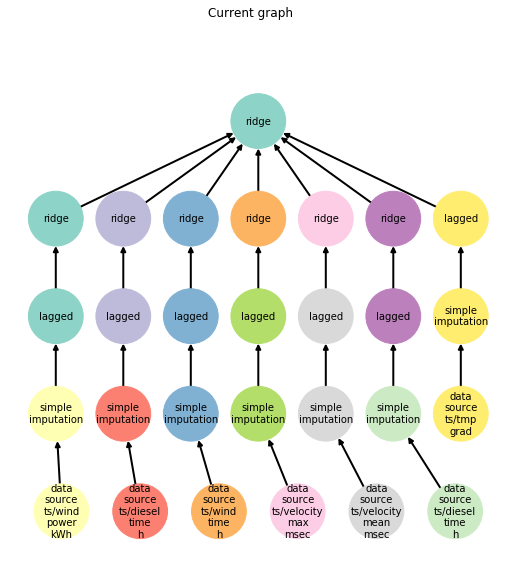

In [20]:
obtained_pipeline.show()

In [21]:
mse_metric = mean_squared_error(ts[-forecast_length:], forecast, squared=False)
mae_metric = mean_absolute_error(ts[-forecast_length:], forecast)
print(f'MAE - {mae_metric:.2f}')
print(f'RMSE - {mse_metric:.2f}')

MAE - 286.01
RMSE - 376.73


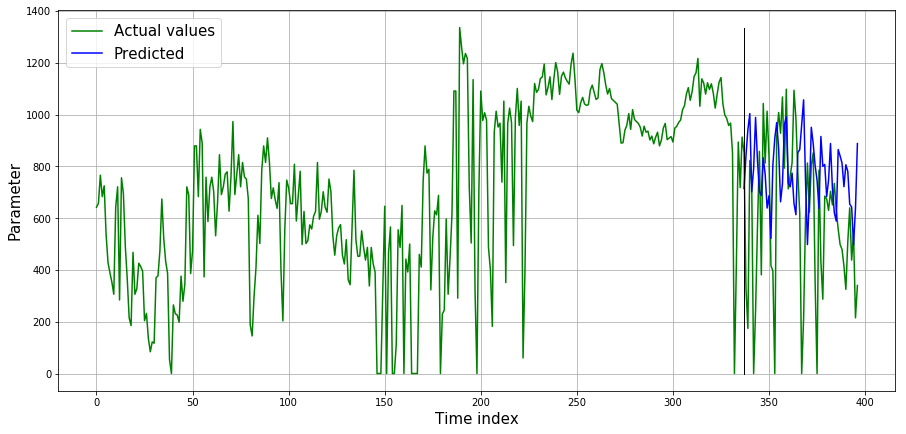

In [23]:
# Visualise predictions
plot_results(actual_time_series=ts,
             predicted_values=forecast,
             len_train_data=len(ts) - forecast_length)